# Bayesian Linear Regression with

<div>
<img src="images/pymc3.jpg" width="200"/>
</div>

### Formation: $y \sim N(X\beta, \sigma^2I)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (20,10)

In [4]:
sns.set(font_scale=2)
sns.set_style('whitegrid')

In [5]:
# generate some data to use to build the linear regression model
# this will be a simple linear regression, meaning there will be one input variable and one
# output variable (y ~ mx + b)

# create 750 observations
n = 750

# the true intercept value is 1.7
b_true = 1.7
# the true beta (coefficient) vale is 2.4
m_true = 2.4
# the observed input values
x_obs = np.linspace(0, 1, n)

# the definition of the true regression line
line_true = b_true + (m_true * x_obs)
# the observed output values
# generated by adding some noise (with zero mean) to the true regression line
y_obs = line_true + np.random.normal(loc=0, scale=0.6, size=n)

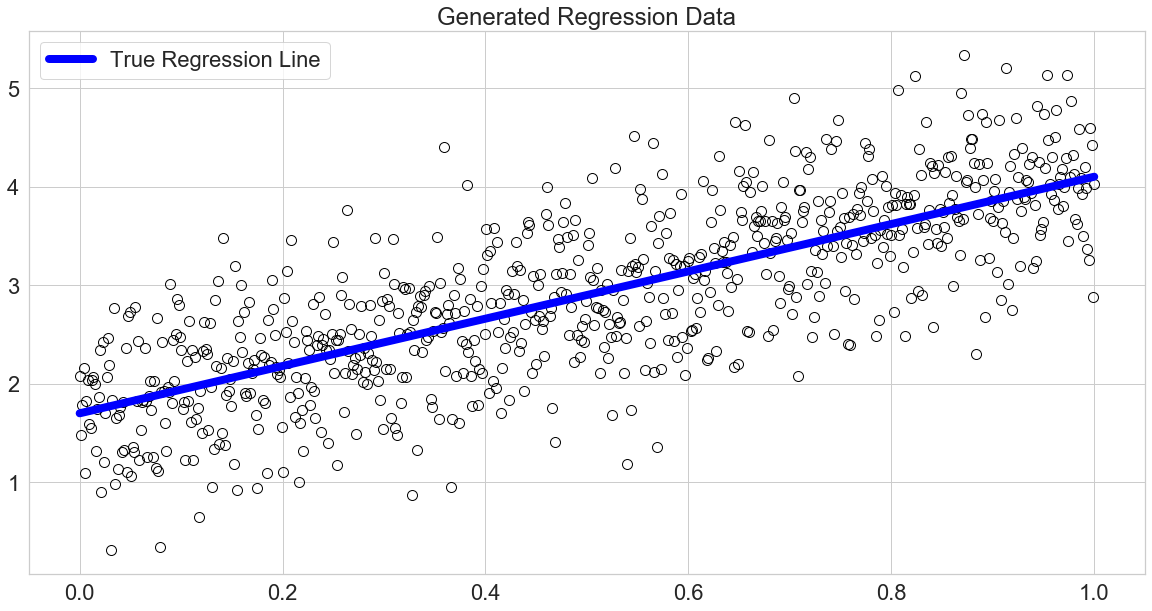

In [6]:
# plot the observed data points with the true regression line

plt.plot(x_obs, y_obs, 'o', mfc='none', c='black', ms=10)
plt.plot(x_obs, line_true, '-', c='blue', lw=8, label='True Regression Line')
plt.title('Generated Regression Data')
plt.legend()
plt.show()

In [7]:
# define the bayesian linear regression model
# sample from the posterior distribution using the No-U-Turn Sampler (NUTS), which is an adaptation
#     of the Hamiltonian Monte Carlo algorithm with built-in solutions for defining the step
#     size and optimal number of steps

with pm.Model() as model:
    
    ##########
    # priors #
    ##########
    # prior for sigma
    #     - p(sigma) ~ halfcauchy(beta=10)
    #     - using half cauchy because sigma cannot be negative and it is weakly informative
    # prior for intercept
    #     - p(intercept) ~ normal(mu=0, sigma=10)
    #     - large sigma value to achieve weakly informative prior
    # prior for coefficient (called x)
    #     - p(coefficient) ~ normal(mu=0, sigma=10)
    #     - large sigma value to achieve weakly informative prior
    sig_prior = pm.HalfCauchy('sigma', beta=10, testval=1.)
    b_prior = pm.Normal('Intercept', 0, sigma=10)
    m_prior = pm.Normal('x', 1, sigma=10)

    ##############
    # likelihood #
    ##############
    # likelihood is the same as formation above, but univariate instead of multivariate 
    # y ~ N(intercept + coefficient * x, sigma^2)
    # use prior values as for intercept, coefficient, and sigma
    likelihood = pm.Normal(
        'y', mu=b_prior + (m_prior * x_obs), sigma=sig_prior, observed=y_obs
    )

    ############
    # sampling #
    ############
    # draw 10,000 samples in 2 chains using 2 cores
    # run convergence checks once sampling is complete
    post_ = pm.sample(
        draws=5000,
        chains=2, 
        cores=2,
        tune=5000,
        progressbar=True,
        discard_tuned_samples=True,
        compute_convergence_checks=True
    )

    ###############
    # predictions #
    ###############
    # compute posterior predictive distributions for each input value in the data
    # take mean of distributions for point predictions
    preds = np.mean(
        pm.sample_posterior_predictive(trace=post_, samples=500, model=model)['y'], 
        axis=0
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [00:25<00:00, 781.74draws/s] 
The acceptance probability does not match the target. It is 0.6881328051854643, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 500/500 [00:00<00:00, 648.13it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2b614510>,
      dtype=object)

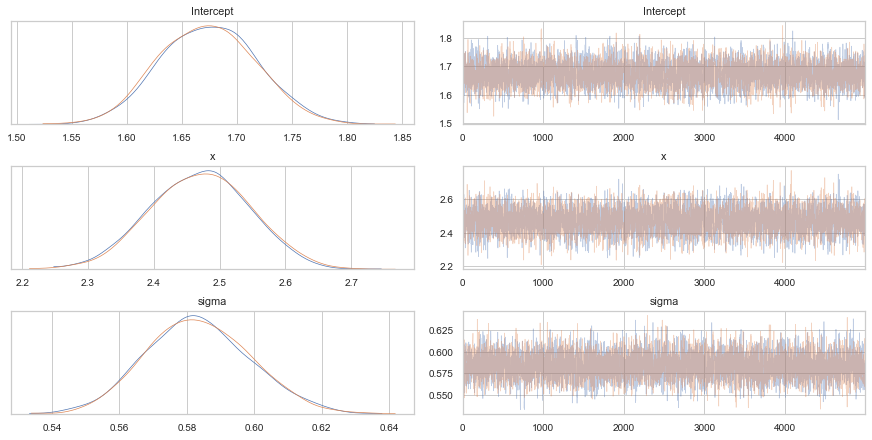

In [8]:
# plot posterior distributions and trace plots
# for every parameter (sigma, intercept, coefficient)

pm.traceplot(post_)

In [9]:
# return summary containing posterior statistics for parameters

pm.summary(post_)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.674,0.043,1.593,1.753,0.001,0.000,4396.0,4379.0,4389.0,4620.0,1.0
x,2.471,0.075,2.328,2.605,0.001,0.001,4434.0,4434.0,4441.0,4398.0,1.0
sigma,0.584,0.016,0.555,0.613,0.000,0.000,5446.0,5446.0,5414.0,4529.0,1.0


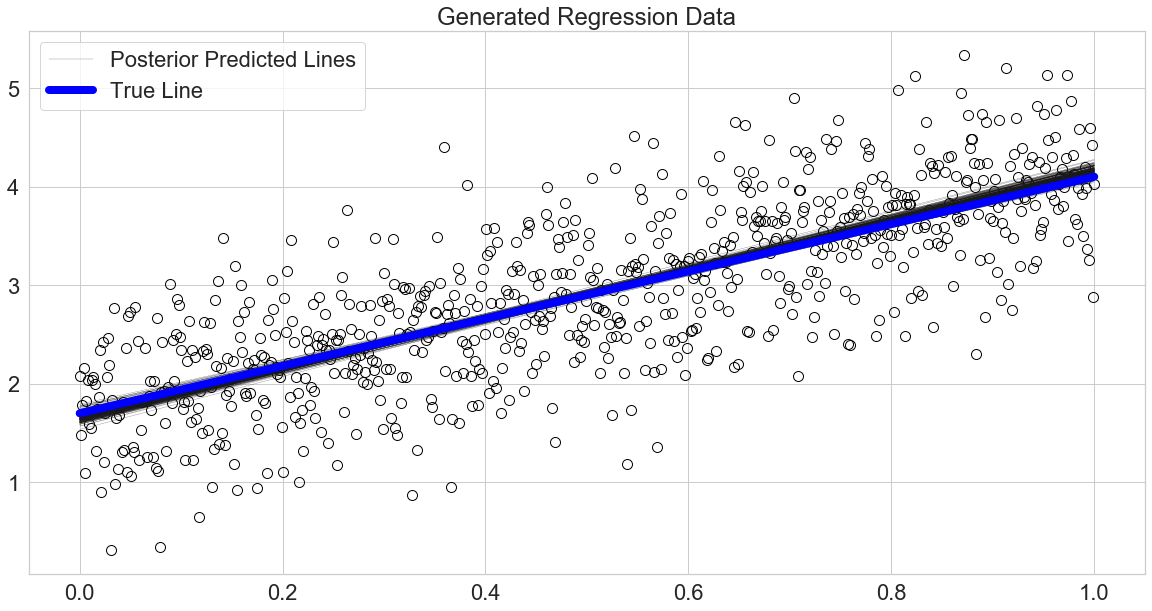

In [10]:
# plot the observed data points with the true regression line as above
# add 250 posterior predicted regression lines
# all the predicted regression lines cluster tightly around the true regression line

plt.plot(x_obs, y_obs, 'o', mfc='none', c='black', ms=10)
pm.plot_posterior_predictive_glm(post_, samples=250, label='Posterior Predicted Lines')
plt.plot(x_obs, line_true, '-', c='blue', lw=8, label='True Line')
plt.title('Generated Regression Data')
plt.legend()
plt.show()

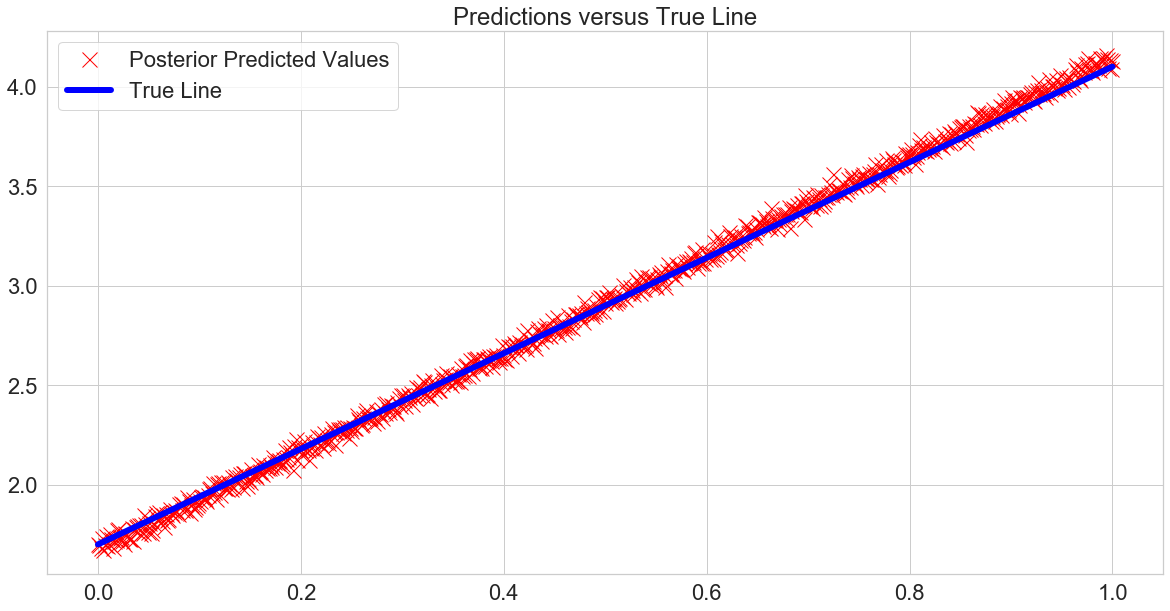

In [11]:
# very similar to the previous plot, but with 500 posterior predicted values
# instead of 250 posterior predicted regression lines

plt.plot(x_obs, preds, 'x', c='red', ms=15, label='Posterior Predicted Values')
plt.plot(x_obs, line_true, '-', c='blue', lw=6, label='True Line')
plt.title('Predictions versus True Line')
plt.legend()
plt.show()